# Практическая работа по распознаванию речи #4: <br> Поиск наилучшей гипотезы распознавания
Задача распознавания речи состоит в поиске наиболее вероятной словной гипотезы по имеющемуся звуковому сигналу. Используя теорему Байеса, формулировку задачи можно написать так:
$$ W^* = \underset{W}{argmax} {P(W|O)} =  \underset{W}{argmax} \sum_i^N{(\log{P(O|w_i)} + \log{P(w_i|w_{i-1}, w_{i-2},..))}}$$
Где: 
* $O$ - звук
* $W$ - словная гипотеза распознавания 
* $W^*$ - лучшая гипотеза распознавания
* $P(W|O)$ - вероятность гипотезы распознавания при условии наблюдения $O$
* $N$ - количество слов в гипотезе
* $w_i$ - i'ое слово в гипотезе
* $P(O|w_i)$ - акустическое правдоподобие слова (выводится из предсказания акустической моделью)
* $P(w_i|w_{i-1}, w_{i-2},..)$ - языковая вероятность слова при условии контекста (предсказывается языковой моделью)


В прошлых лабораторных работах были изучены акустическая и языковая модели. Акустическая модель предсказывает вероятность принадлежности кадра некоему акустическому классу (фонеме). Языковая модель предсказывает априорную вероятность последовательности слов. Пришло время разобраться, как соединить эти части в одну систему и получить итоговый результат распознавания. 





Основная часть (14 баллов) данной практической работы состоит из двух частей: 
* знакомство с Weighted Finite State Transducer (WFST)
* WFST декодинг в ASR системе

Дополнительная часть - тюнинг параметров (2 балла)

## Полезные ссылки: 
* Наиболее популярная библиотека WFST - [OpenFst](https://www.openfst.org/twiki/bin/view/FST/WebHome)
* Библиотека для визуализации - [graphviz](https://graphviz.readthedocs.io/en/stable/manual.html)
* Алгоритм обхода графа в ширину - [BFS](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D0%B1%D1%85%D0%BE%D0%B4_%D0%B2_%D1%88%D0%B8%D1%80%D0%B8%D0%BD%D1%83)

In [1]:
!python --version 

Python 3.10.12


In [2]:
# !pip install graphviz kenlm kaldiio jiwer

In [3]:
import numpy as np
import time
import os
import abc

from typing import List, Dict, Union, Set, Any, Optional, Tuple
from tqdm.auto import tqdm
from collections import defaultdict
from pathlib import Path
from dataclasses import dataclass

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import graphviz
import kenlm 
import jiwer
from kaldiio import ReadHelper

# 1. Weighted Finite State Transducer (WFST)



Из определения в wiki [Weighted Finite State Transducer (Взвешенный конечный автомат с выходом)](https://en.wikipedia.org/wiki/Finite-state_transducer) следует, что главная задача FST, --- это переводить символы из входного алфавита в соответствующие им символы из выходного алфавита. Например, с помощью FST можно перевести последовательность фонем в последовательность слов. Конечный автомат будет менять свое состояние при обработке последовательности входных символов (фонем). Когда он соберет из входных фонем корректную транскрипцию слова, то выдаст это слово на выход. 

Однако не всегда можно однозначно перевести последовательность фонем в слова (некоторые слова произносятся одинаково, а пишутся по-разному), поэтому для распознавания речи надо использовать не простой FST, а взвешенный. WFST позволяет не только перевести входные символы в выходные, но и оценить вес такого перевода. Чем больше вес, тем хуже гипотеза.  

Напишем собственную реализацию WFST.


### AbstractWFST
AbstractWFST -- это базовый интерфейс нашего WFST. В нем заданы основные методы, через которые мы будем работать с wfst  
* get_start - возвращаяет стартовое состояние конечного автомата.
* final_score - вес завершения работы в данном состоянии. В некоторых состояниях завершить обработку невозможно, в таких случаях final weight  будет равен бесконечности.
*  transduce - совершает переход из текущего состояния в следующее, соответствующее переходу по символу ilabel. Возвращает выходной символ, вес перехода и следующее состояние.  




 

In [4]:
class AbstractWFST(abc.ABC):
    def __init__(self):
        pass
    
    @abc.abstractmethod
    def get_start(self) -> Any:
        """Return start state"""
    
    @abc.abstractmethod
    def final_score(self, state: Any) -> float:
        """is the state final? If true return negative log likelihood of the finalization. otherwise return inf"""
           
    @abc.abstractmethod
    def transduce(self, state: Any, ilabel: str) -> Tuple[Tuple[str, float, Any]]:
        """Transduce ilabel to olabel. 
        return all available olabels for this state and ilabel pair
        return type - ((olabel1, weight1, nextstate1), 
                       ((olabel1, weight1, nextstate1), 
                       ...)"""

### SymbolsMap

Для того, чтобы задать WFST, первым делом нам понадобятся таблицы входных и выходных символов. Для задания таблиц будем использовать класс SymbolsMap. Данный класс служит для маппинга символов на индексы и обратно. 

In [5]:
class SymbolsMap:
    def __init__(self, id2symbol: Optional[Dict[int, str]] = None, symbol2id: Optional[Dict[str, int]] = None):
        assert id2symbol is not None or symbol2id is not None, f"One id2symbol or symbol2id must be not None"
        assert id2symbol is None or symbol2id is None, f"Only one One id2symbol or symbol2id can be not None"
        if id2symbol is None:
            self.id2symbol = {i:s for s,i in symbol2id.items()}
        elif isinstance(id2symbol, dict):
            self.id2symbol = id2symbol
        elif isinstance(id2symbol, list):
            self.id2symbol = {i:s for i, s in enumerate(id2symbol)}
        else:
            raise RuntimeError(f"unknown type {type(id2symbol)=}")
            
        if symbol2id is None:
            self.symbol2id = {s:i for i, s in self.id2symbol.items()}
        else:
            self.symbol2id = symbol2id   
                
        assert self.id2symbol[0] == '<eps>', f"wrong {self.id2symbol}"

    def get_id(self, symbol: str):
        return self.symbol2id[symbol]
        
    def get_symbol(self, id: int):
        return self.id2symbol[id] 
    
    @classmethod
    def from_file(cls, fname):
        """read symbols table from file
        format: 
            word id
            word2 id2
            ...
        """
        with open(fname) as f:
            s2i = {s:int(i) for s, i in map(str.split, f.readlines())}
        return cls(symbol2id=s2i)

### Arc и ILabelIndexedArcs
Переходы внутри FST будем описывать с помощью класса, инкапсулирующего информацию о входном/выходном индексе символа, весе перехода и следующем состоянии FST. Поскольку дуги мы будем хранить отдельно для каждого состояния, информация о текущем состоянии в дуге не нужна. 

Для быстрого выбора нужной дуги создадим специальную коллекцию ILabelIndexedArcs. Данная коллекция хранит дуги таким образом, чтобы выбор дуги по входному символу осуществлялся за O(1). 


In [6]:
@dataclass
class Arc:
    """Arc in WFST"""
    ilabel: int
    olabel: int
    weight: float
    nextstate: Any

class ILabelIndexedArcs:
    def __init__(self, arcs: Optional[List[Arc]] = None):
        self.ilabel2arclist = defaultdict(list)
        if arcs is not None:
            for arc in arcs:
                self.add_arc(arc)

    def add_arc(self, arc: Arc):
        self.ilabel2arclist[arc.ilabel].append(arc)

    def get_arcs_by_ilabel(self, ilabel: int):
        return self.ilabel2arclist[ilabel]

    def arcs(self) -> List[Arc]:
        """Return all arcs"""
        all_arcs = []
        # TODO
        # реализуйте функцию, которая возвращает все дуги, хранящиеся в данной коллекции
        # raise NotImplementedError()
        # !!!!!!!!!!!!
        all_arcs = [arc for arc_list in self.ilabel2arclist.values() for arc in arc_list]
        return all_arcs 

    def __str__(self):
        return "ILabelIndexedArcs([" + ", ".join(f"{a}" for a in self.arcs()) + "])"

    def __repr__(self):
        return str(self)

In [7]:
# test 1.a
def test_ILabelIndexedArcs():
    # проверка что arcs работает правильно
    arcs = [Arc(i, -i, i/100, i+100) for i in range(10)]
    c = ILabelIndexedArcs(arcs)
    arcs2 = c.arcs()
    assert len(arcs) == len(arcs2), f"{len(arcs)=}, {len(arcs2)=}\n{arcs} != {c.arcs()}"
    for a in arcs2:
        assert a in arcs, f"{a=} not in {arcs=}"
    print('Test 1.a passed')
test_ILabelIndexedArcs()

Test 1.a passed


### WFST 
Все готово для создания взвешенного конечного автомата. Класс WFST состоит из таблицы входных и выходных символов, списка состояний и коллекции дуг для каждого, а также множества финальных состояний. 

In [8]:
class WFST(AbstractWFST):
    def __init__(self,
                 isymbols: Optional[SymbolsMap] = None,
                 osymbols: Optional[SymbolsMap] = None):
        self.start = 0
        self.states = [0]
        # состояния, в которых может завершиться декодирование без какого либо штрафа 
        self.final_states = set() 
        self.isymbols = isymbols
        self.osymbols = osymbols
        self.state2arcs = defaultdict(ILabelIndexedArcs)

    def get_start(self):
        """return start state"""
        return self.start

    def final_score(self, state_id: int):
        """return the weight of decoding completion in state_id"""
        # TODO
        # верните вес завершения декодирования в state_id
        # raise NotImplementedError()
        # !!!!!!!!!!!!!!!!!!!
        if state_id in self.final_states:
            return 0.0
        else:
            return float('inf')
       
    def transduce(self, state, ilabel: str) -> Tuple[Tuple[str, float, int]]:
        """transitions wfst to next state by 'ilabel' input symbol, except when the input symbol is <eps>.
        Returns all possible output results as a tuple of triples (olabel, weight, nextstate)."""
        assert self.isymbols is not None and self.osymbols is not None, f"Cannot transduce w/o both symbols tables" 
        if ilabel == '<eps>':
            # skip <eps> input
            return ((ilabel, 0, state), )
        label_id = self.isymbols.get_id(ilabel)
        # TODO 
        # верните все возможные результаты перехода из текущего состояния по входу ilabel
        # результат должен выглядеть так: tuple(("слово", 0.1, 2), ("другоеслово", 10, 4), ...)
        # raise NotImplementedError()
        # !!!!!!!!!!!!
        arcs_container = self.state2arcs[state]
        arcs = arcs_container.get_arcs_by_ilabel(label_id)
        transductions = [(self.osymbols.get_symbol(arc.olabel) if self.osymbols is not None else arc.olabel,
                          arc.weight, arc.nextstate) for arc in arcs]
        return tuple(transductions)
    
    def set_final(self, state: int):
        """sets the final weight for the state to zero"""
        # TODO добавьте возможность завершать декодирование в state
        self.final_states.add(state)
        # raise NotImplementedError()
        # !!!!!!!!!!!

    def new_state(self):
        """Create new state id and return it"""
        # TODO 
        # добавьте в конечный автомат новое состояние и верните его id 
        state_id = max(self.states) + 1
        self.states.append(state_id)
        # raise NotImplementedError()
        # !!!!!!!!
        return state_id

    def add_arc(self, state_from: int, arc: Arc):
        """adds a new arc for this state"""
        # TODO 
        # добавьте в конечный автомат новых переход arc, выходящий из state_from
        # raise NotImplementedError()
        # !!!!!!!!!!!!!!!!!!
        self.state2arcs[state_from].add_arc(arc)

    def to_dot(self):
        """Visualize the WFST""" 
        dot = graphviz.Digraph()
        for s in self.states:
            dot.node(str(s))
        for state_from, arcs_container in self.state2arcs.items():
            for arc in arcs_container.arcs():
                il = self.isymbols.get_symbol(arc.ilabel) if self.isymbols is not None else arc.ilabel
                ol = self.osymbols.get_symbol(arc.olabel) if self.osymbols is not None else arc.olabel
                dot.edge(str(state_from), str(arc.nextstate), label=f"{il}:{ol}:{arc.weight:.2f}")
        return dot

In [9]:
# test 1.b
def test_WFST():
    en_l = SymbolsMap(id2symbol=['<eps>', 'b', 'd', 'u'])
    ru_l = SymbolsMap(id2symbol=['<eps>', 'ю', 'б', 'д'])
    
    # create first transducer
    en2ru = WFST(isymbols=en_l, osymbols=ru_l)
    # new_state
    en2ru_final = en2ru.new_state()
    assert en2ru_final == 1 , f'start - zero, next state - one, next - two ...'
    assert en2ru.new_state() == 2, f'start - zero, next state - one, next - two ...'
    en2ru.set_final(en2ru_final)
    en2ru.add_arc(en2ru.get_start(), Arc(1, 2, 1.0, en2ru_final))
    en2ru.add_arc(en2ru_final, Arc(2, 3, 2.0, en2ru.get_start()))
    en2ru.add_arc(en2ru.get_start(), Arc(3, 1, 3.0, en2ru_final))
    # you can use this line to visualize
    #display.display(en2ru.to_dot())

    # final_score # set_final
    assert en2ru.final_score(en2ru.get_start()) == float('inf')
    assert en2ru.final_score(en2ru_final) == 0
    en2ru.set_final(en2ru.get_start())
    assert en2ru.final_score(en2ru_final) == en2ru.final_score(en2ru.get_start()) == 0

        
    # transduce # add_arc
    assert en2ru.transduce(en2ru.get_start(), 'd') == tuple() , "Cannot transduce 'd' from start state. output must be zero len tuple"
    assert en2ru.transduce(en2ru.get_start(), 'b') == (('б', 1.0, en2ru_final), ) , "Arc(1, 2, 1.0, en2ru_final)"
    assert en2ru.transduce(en2ru.get_start(), 'u') == (('ю', 3.0, en2ru_final), ) , "Arc(3, 1, 3.0, en2ru_final)"
    assert en2ru.transduce(en2ru_final, 'd') == (('д', 2.0, en2ru.get_start()), ) , "Arc(2, 3, 2.0, en2ru.get_start())"
    
    print('test 1.b passed')
test_WFST()

test 1.b passed


## wfst композиция 


Над WFST определен большой набор различных операций, реализация большинства из которых является сложной алгоритмической задачей. Важной для распознавания речи операцией является [композиция](https://www.openfst.org/twiki/bin/view/FST/ComposeDoc) набора различных wfst. 

OpenFST дает следующее определение композиции:
 
"This operation computes the composition of two transducers. If A transduces string x to y with weight a and B transduces y to z with weight b, then their composition transduces string x to z with weight a ⊗ b."

Другими словами, результатом композиции является wfst, применение которого к входной последовательности даст такой же результат, как и последовательное применение композируемых wfst. 

Хорошим примером композиции различных WFST является граф распознавания в гибридных системах распознавания речи. Такой граф является результатом композиции четырех wfst:
* H - Hidden Markov Model wfst (переводит акустические классы, предсказанные с помощью AM, в трифоны)
* С - Context-dependency transducer (переводит трифоны (тройки (leftcontext,phone,rightcontext)) в фонемы)
* L - lexicon (переводит фонемы в слова)
* G - ngram lm (оценивает вероятность последовательностей слов)
 
Итого граф распознавания можно выразить с помощью следующей формулы:
$$ HCLG = H⊗C⊗L⊗G $$ 
где ⊗ - оператор композиции двух wfst. Подробнее про граф распознавания можно почитать в [документации к фреймворку kaldi](https://kaldi-asr.org/doc/graph.html)


Композиция позволяет объединить много обработчиков в один большой граф, что несомненно является большим плюсом для построения продакшн решений. Но у такого подхода есть и минусы - процесс подготовки графа очень сложен и требует множества оптимизаций. Это усложняет любые эксперименты и модификации системы. В данной работе мы не будем реализовывать честную композицию графа, а будем считать композицию "On the Fly". То есть сделаем обертку, реализующую интерфейс AbstractWFST, состоянием которой будет Tuple состояний всех композируемых wfst, а метод transduce будет последовательно проходить через эти wfst. Тем самым, по определению композиции, наш класс будет эквивалентен честной композиции.  



In [10]:
class OnTheFlyCompose(AbstractWFST):
    def __init__(self, wfsts: List[AbstractWFST]):
        # !!!Attention!!! wfsts - это лист AbstractWFST, а не WFST. 
        # Для работы с wfsts истользуйте только методы из AbstractWFST
        self.wfsts = wfsts

    def get_start(self):
        return tuple(fst.get_start() for fst in self.wfsts)

    def final_score(self, state: Tuple[Any]):
        assert len(state) == len(self.wfsts)
        # TODO 
        # посчитайте финальный скор для state
        # результат композиции может завершить обработку только в тех стейтах, где все wfsts будут в финальных состояниях
        # raise NotImplementedError()
        # !!!!!!!!!!!!!!!!!!!!!
        return sum(fst.final_score(s) for fst, s in zip(self.wfsts, state))
    
    def _transduce(self, state: Tuple[Any], ilabel: str) -> List[Tuple[List[str], float, List[int]]]:
        assert len(self.wfsts) == len(state)
        # Найдите все возможные гипотезы перевода ilabel с помощью композиции всех self.wfsts
        # Последовательно пройдите через все self.wfsts, расширяя список гипотез и дополняя гипотезы новыми слоями 
        # Верните результат в виде списка гипотез. 
        # Каждая гипотеза содержит три элемента: 
        #   0. список символов со ВСЕХ прошедших слоев композиции
        #   1. суммарный вес гипотезы
        #   2. список состояний, в которые перешли self.wfsts

        # Одна стартовая гипотеза. Корень для всех гипотез.
        # Еще никакой wfst не применен, символ только ilabel, вес стартовый, стейтов еще нет. 
        hyps_per_layer = [([ilabel], 0, [])]
        for fst, s in zip(self.wfsts, state):
            new_hyps = []
            # TODO
            # примените fst.transduce ко всем гипотезам из hyps_per_layer
            # постепенно разветвляя их и сохраняя в new_hyp
            # на вход подайте выход последнего из уже обработаных слоев
            # raise NotImplementedError()
            # !!!!!!!!!
            for ls, w, ss in hyps_per_layer:
                for olabel, ow, os in fst.transduce(s, ls[-1]):
                    new_ls, new_w, new_ss = list(ls), w + ow, list(ss)
                    
                    new_ls.append(olabel)
                    new_ss.append(os)
                    new_hyps.append((new_ls, new_w, new_ss))

            hyps_per_layer = new_hyps

        return hyps_per_layer

    def transduce(self, state: Tuple[Any], ilabel: str):
        hyps_per_layer = self._transduce(state, ilabel)
        # выходной символ transduce в композиции - это выходной символ самого последнего wfst 
        return tuple((ls[-1], w, tuple(ss)) for ls, w, ss in hyps_per_layer)

In [11]:
def test_OnTheFlyCompose():
    en_l = SymbolsMap(id2symbol=['<eps>', 'b', 'd', 'u'])
    ru_l = SymbolsMap(id2symbol=['<eps>', 'ю', 'д', 'б'])
    en_U = SymbolsMap(id2symbol=['<eps>', 'B', 'D', 'U'])
    ru_U = SymbolsMap(id2symbol=['<eps>', 'Ю', 'Д', 'Б'])
    
    # create first transducer
    en2ru = WFST(isymbols=en_l, osymbols=ru_l)
    en2ru_final = en2ru.new_state()
    en2ru.set_final(en2ru_final)
    en2ru.add_arc(en2ru.get_start(), Arc(1, 3, 1.0, en2ru_final))
    en2ru.add_arc(en2ru_final, Arc(2, 2, 2.0, en2ru.get_start()))
    en2ru.add_arc(en2ru.get_start(), Arc(2, 0, 0.1, en2ru.get_start()))
    en2ru.add_arc(en2ru.get_start(), Arc(3, 1, 3.0, en2ru_final))
    # you can use this line to visualize
    # display.display(en2ru.to_dot())

    # OnTheFlyCompose одного fst работает так же как и этот fst
    comp = OnTheFlyCompose([en2ru])
    for s in (0, 1):
        for il in 'bdu':
            hyps1 = en2ru.transduce(s, il)
            hyps2 = comp.transduce((s,), il)
            for h in hyps2:
                # only one state
                assert len(h[2]) == 1, f"{hyps2=}"
            hyps2_flatten = tuple((l, w, ss[0]) for l,w,ss in hyps2)
            assert hyps1 == hyps2_flatten, f"{hyps1=} {hyps2_flatten=}"

    # create second transducer
    ru2en = WFST(isymbols=ru_l, osymbols=en_U)
    ru2en_final = ru2en.new_state()
    ru2en.set_final(ru2en_final)
    ru2en.add_arc(ru2en.get_start(), Arc(3, 1, 10.0, ru2en_final))
    ru2en.add_arc(ru2en_final, Arc(2, 2, 20.0, ru2en_final))
    ru2en.add_arc(ru2en_final, Arc(2, 2, 30.0, ru2en.get_start()))
    ru2en.add_arc(ru2en_final, Arc(1, 3, 40.0, ru2en.get_start()))
    
    # you can use this line to visualize
    # display.display(ru2en.to_dot())

    # композиция двух работает как последовательное применение каждого 
    comp = OnTheFlyCompose([en2ru, ru2en])
    hyps = comp.transduce((0, 0), 'b')
    assert hyps == (('B', 11.0, (1, 1)), ) , f"{hyps =}"
    hyps = comp.transduce((1, 1), 'd')
    assert hyps == (('D', 22.0, (0, 1)), ('D', 32.0, (0, 0))) , f"{hyps =}"
    hyps = comp.transduce((0, 1), 'd')
    assert hyps == (('<eps>', 0.1, (0, 1)), ) , f"{hyps =}"
    print('Test 1.c passed')

test_OnTheFlyCompose()

Test 1.c passed


# 2. WFST декодинг в ASR системе
Отлично, код WFST готов, теперь необходимо собрать граф распознавания и написать поиск наилучшей гипотезы 




In [12]:
# Сначала подготовим нужные нам таблицы символов
AM_PHONES = {0: 'pau', 1: 'aa', 2: 'ae', 3: 'ah', 4: 'ao', 5: 'aw', 6: 'ax', 7: 'ax-h', 8: 'axr', 9: 'ay', 10: 'b', 
             11: 'bcl', 12: 'ch', 13: 'd', 14: 'dcl', 15: 'dh', 16: 'dx', 17: 'eh', 18: 'el', 19: 'em', 20: 'en', 
             21: 'eng', 22: 'er', 23: 'ey', 24: 'f', 25: 'g', 26: 'gcl', 27: 'hh', 28: 'hv', 29: 'ih', 30: 'ix', 
             31: 'iy', 32: 'jh', 33: 'k', 34: 'kcl', 35: 'l', 36: 'm', 37: 'n', 38: 'ng', 39: 'nx', 40: 'ow', 
             41: 'oy', 42: 'p', 43: 'pcl', 44: 'q', 45: 'r', 46: 's', 47: 'sh', 48: 't', 49: 'tcl', 50: 'th', 
             51: 'uh', 52: 'uw', 53: 'ux', 54: 'v', 55: 'w', 56: 'y', 57: 'z', 58: 'zh'}

# таблица фонем для wfst 
def create_phones_txt(fname='exp/phones.txt'):
    fname = Path(fname)
    fname.parent.mkdir(exist_ok=True, parents=True)
    with open(fname, 'w') as f:
        f.write('<eps> 0\n') # !! shift all ids by one !!
        for i, p in sorted(AM_PHONES.items()):
            f.write(f'{p} {i+1}\n')
create_phones_txt()

In [13]:
# Загрузим подготовленный лексикон из датасета 
def load_lexicon_file(fname='timit/TIMITDIC.TXT', words_limit=-1):
    """generator running through the 'fname' phonetic dictionary 
    yield (word: str, phones: List[str])"""
    num = 0
    with open(fname) as f:
        for line in map(str.strip, f.readlines()):
            if line.startswith(';'):
                continue
            word, trans, _ = line.split('/')
            # remove ~adj suffix 
            word = word.split('~')[0].strip() 
            # remove stress factor
            trans = [t[:-1] if t[-1].isdigit() else t for t in trans.split()]
            yield word, trans
            num += 1
            if words_limit == num:
                break

In [14]:
# подготовим таблицу слов
def create_words_txt(fname='exp/words.txt', dic_fname='timit/TIMITDIC.TXT'):
    fname = Path(fname)
    fname.parent.mkdir(exist_ok=True, parents=True)
    words = ['<eps>'] + [w for w, _ in sorted(load_lexicon_file(dic_fname))] + ['<s>', '</s>']
    with open(fname, 'w') as f:
        f.write(''.join(f'{w} {i}\n' for i, w in enumerate(words)))
create_words_txt()

# H transducer

Создадим первый wfst. 

В гибридном пайплайне задача первых двух wfst (H и C) - это перевести предсказанные с помощью акустической модели классы в последовательность фонем. В нашем случае все значительно легче, тк как АМ (из работы №3) уже учится предсказывать фонемы. H.wfst остается только преобразовать вероятност, которые оценивает AM, в правдоподобие, добавив к скорам фонем их априорную вероятность. 


Необходимый нам для декодирования граф H.wfst состоит из одного состояния и N петель, где N - это количество фонем. Каждая петля соответствует определенной фонеме и хранит ее логарифм априорной вероятности.

![image](resources/lab4/H_example.svg)

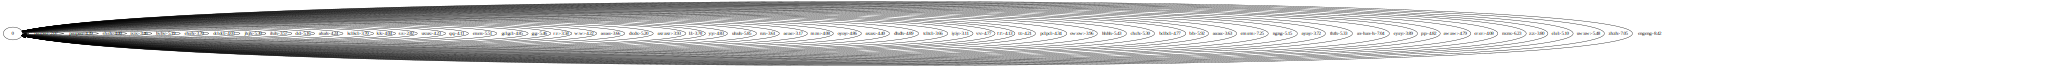

In [15]:
def create_h_wfst(prior_file='resources/lab4/phone.priors', phones_fname='exp/phones.txt'):
    """Create H.wfst. just transduce AM probability to AM likelihood (Bayes theorem)
    """
    symbols = SymbolsMap.from_file(phones_fname)
    h_fst = WFST(isymbols=symbols, osymbols=symbols)
    s = h_fst.get_start()
    h_fst.set_final(s)
    with open(prior_file) as f:
        for ph, prior in map(str.split, f.readlines()):
            log_prior = np.log(float(prior))
            ph_id = symbols.get_id(ph)
            h_fst.add_arc(s, Arc(ph_id, ph_id, log_prior, s))
    return h_fst
create_h_wfst().to_dot()

# L transducer

Lwfst - это WFST, который преобразует входные последовательности фонем в слова.

Например, `pau pau ae1 ae1 ae1 ae1 ae1 ae1 r pau pau pau y y y y eh1 s s s pau` -> `air yes`

Чтобы контролировать количество слов в выходной гипотезе, в L добавляется два веса: 
* word_insertion_penalty - штраф за добавление слова 
* stay_in_silence_penalty - штраф за пропуск паузы (фонемы pau)

Пример Lwfst, построенного для слов `'em` `-knacks`, с параметрами word_insertion_penalty=0.5, stay_in_silence_penalty=0.01

![image](./resources/lab4/L_example.svg)

Фонема паузы pau обрабатывается особым способом: L.fst может пропускать ее, не генерируя ничего на выходе. Также у окончания каждой транскрипции слова есть две отдельные дуги, возвращающие FST в стартовое состояние. Это нужно для того, чтобы была возможность обработать как подряд дупликаты последней фонемы на конце слова, так и перейти в стартовое состояние всего по одной финальной фонеме. 

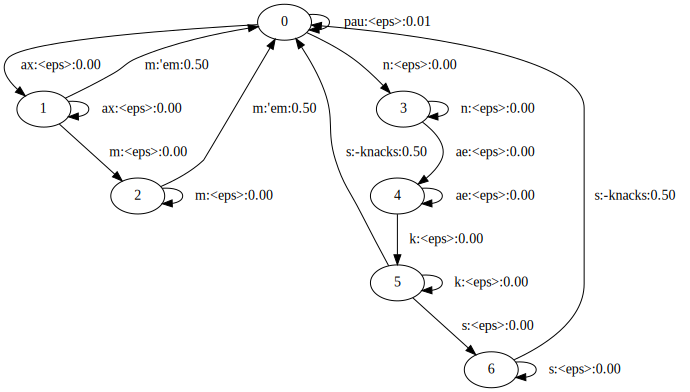

In [16]:
def create_Lwfst_from_file(dic_fname='timit/TIMITDIC.TXT', 
                           phones_fname='exp/phones.txt', 
                           words_fname='exp/words.txt', 
                           words_limit=-1,
                           word_insertion_penalty=0.5, 
                           stay_in_silence_penalty=0.01):
    isymbols = SymbolsMap.from_file(phones_fname)
    osymbols = SymbolsMap.from_file(words_fname)
    sil_id = isymbols.get_id('pau')
    l_wfst = WFST(isymbols=isymbols, osymbols=osymbols)
    start = l_wfst.get_start()
    ### Пропуск скольких угодно фонем тишины
    l_wfst.add_arc(start, Arc(sil_id, 0, stay_in_silence_penalty, start))
    # Стартовое состояние также является и финальным
    l_wfst.set_final(start)
    
    for word, trans in load_lexicon_file(dic_fname, words_limit=words_limit):
        tran_ids = [isymbols.get_id(t) for t in trans]
        word_id = osymbols.get_id(word)
        # TODO 
        # Добавьте последовательные дуги в wfst, определяющие транскрипцию слова
        # Все дуги, кроме последней, на выходе имеют <eps>
        # Последняя дуга выводит word_id и возвращает конечный автомат в стартовое (оно же финальное) состояние
        # Каждая фонема может тянуться от 1 до inf кадров, поэтому помимо переходов в новое состояние, должны быть еще петли 
        # raise NotImplementedError()
        prev_state = start
        for i, phone_id in enumerate(tran_ids):
            state = l_wfst.new_state()
            l_wfst.add_arc(prev_state, Arc(phone_id, 0, 0, state))
            l_wfst.add_arc(state, Arc(phone_id, 0, 0, state))
            if i+1==len(tran_ids):
                l_wfst.add_arc(prev_state, Arc(phone_id, word_id, word_insertion_penalty, start))
                l_wfst.add_arc(state, Arc(phone_id, word_id, word_insertion_penalty, start))
            prev_state = state
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
    return l_wfst
create_Lwfst_from_file(words_limit=2, word_insertion_penalty=0.5, stay_in_silence_penalty=0.01).to_dot()

In [17]:
def test_l_wfst():
    l_wfst = create_Lwfst_from_file(dic_fname='timit/TIMITDIC.TXT', 
                                    word_insertion_penalty=1.0, stay_in_silence_penalty=0.01)
    start = l_wfst.get_start()
    hyps = l_wfst.transduce(start, 'pau')
    loop_hyp = [(l, w, s) for l, w, s in hyps if s == start]
    assert (len(loop_hyp) == 1 
            and loop_hyp[0][0] == '<eps>' 
            and loop_hyp[0][1] == 0.01), f"{hyps}\n skip pause test failed"
    # смотрим, что поданная на вход транскрипция корректно переводится в слово
    # количество подряд идущих одинаковых фонем постепенно увеличивается от одной до 6
    for i, (word, trans) in enumerate(tqdm(load_lexicon_file('timit/TIMITDIC.TXT', words_limit=100), total=100)):
        hyps = [('', 0, l_wfst.get_start()), ]
        # Breadth First Search
        for t in [t for t in trans for _ in range(i//20+1)]:
            # t repeated many times
            new_hyps = []
            for prev_l, prev_w, prev_s in hyps: 
                new_hyps.extend([(f"{prev_l} {l}", prev_w + w, s) for l,w,s in l_wfst.transduce(prev_s, t)])
            hyps = new_hyps
        # choose only final hyp
        # ограничение веса нужно, чтобы отсечь гипотезы где комбинация других слов мапится на теже фонемы
        hyps = [(l, w, s) for l, w, s in hyps if l_wfst.final_score(s) != float('inf') and w == 1.0]
       
        assert len(hyps) == 1 or len(trans) == 1 , f"Test failed for word \"{word}\" {hyps=}"
        assert hyps[0][0].replace('<eps>', ' ').split() == [word], f"Test failed for word {word} {hyps=}"
        assert hyps[0][1] == 1.0, f"Test failed for word {word} {hyps=}"
        assert hyps[0][2] == start, f"Test failed for word {word} {hyps=}"       
    print("test 2.a passed")
test_l_wfst()

  0%|          | 0/100 [00:00<?, ?it/s]

test 2.a passed


# Поиск наилучшей гипотезы распознавания с помощью beam search

Для того, чтобы найти результат распознавания с помощью акустической модели и графа распознавания, надо выполнить поиск наилучшей гипотезы в графе. Для поиска лучшего пути будем использовать [лучевой поиск (Beam Search)](https://ru.wikipedia.org/wiki/%D0%9B%D1%83%D1%87%D0%B5%D0%B2%D0%BE%D0%B9_%D0%BF%D0%BE%D0%B8%D1%81%D0%BA). В основе этого алгоритма лежит обход графа в ширину, но на каждом шаге рассматриваются только наиболее "хорошие" гипотезы, а остальные уничтожаются. Такая эвристика позволяет значительно ускорить процесс декодирования, но не всегда находит наилучший путь. 

In [18]:
@dataclass(order=True)
class Hypothesis:
    # накопленный штраф гипотезы
    score: float
    # до какого кадра из входной последовательности дошла гипотеза
    time: int
    # накопленная последовательность слов
    words: List[str]
    # состояние графа декодирования 
    state: Any


### HypothesesKeeper
Реализуем специальную коллекцию, которая хранит все гипотезы распознавания и применяет прунинг (удаление ненужных гипотез). 
Прунинг делится на два типа: 
#### State pruning 
Eсли мы можем дойти до состояния X в момент времени T несколькими способами, то для дальнейшей обработки достаточно только наилучшего пути до состояния X. Эта гипотеза гарантированно будет лучше всех других гипотез, проходящих через точку (X, T). 
#### Beam pruning
Эвристика лучевого поиска. Отсекаем все гипотезы, которые хуже, чем лучшая текущая гипотеза плюс beam_size. Вероятность того, что гипотезы с сильно худшим весом вдруг станут наилучшими, крайне мала, поэтому такая эвристика работает достаточно хорошо. 


In [19]:
class HypothesesKeeper:
    def __init__(self, init_hyps: List[Hypothesis] = [], beam_size=10):
        self.state2hyp = {h.state: h for h in init_hyps}
        self.beam_size = beam_size
        if len(self.state2hyp) == 0:
            self.set_best(None, float('inf'))
        else:
            min_hyp = min(self.state2hyp.values())
            self.set_best(min_hyp.state, min_hyp.score)

    def set_best(self, state, score):
        self.best_state = state
        self.best_score = score
        
    def get_best_hyp(self) -> Hypothesis:
        """return the best hyp based on self.best_state"""   
        # TODO 
        # верните лучшую гипотезу 
        # raise NotImplementedError()
        # !!!!!!!!!!
        return self.state2hyp[self.best_state]
    
    def prune(self):
        self.state2hyp = {s:h for s, h in self.state2hyp.items() if not self.is_prunned_by_beam(h.score)}
        
    def tolist(self) -> List[Hypothesis]:
        """Return all hypotheses. Apply beam pruning"""
        # TODO 
        # верните все гипотезы, которые находятся в луче поиска 
        # raise NotImplementedError()
        # !!!!!!!!!!!!!!!!!
        return [h for h in self.state2hyp.values() if not self.is_prunned_by_beam(h.score)]
    
    def is_prunned_by_beam(self, score: float):
        """Return true if score greater than beam"""
        # TODO 
        # верните True, если значение score находится вне луча поиска 
        # raise NotImplementedError()
        #!!!!!!!!!!!!!!!!
        return score > self.best_score + self.beam_size
        
    def is_prunned_by_state(self, state, score):
        """Returns true if the keeper already has a hyp in the same state and the score of this hyp is lower"""
        # TODO
        # верните True, если state уже имеет гипотезу, со скором лучше чем score
        # raise NotImplementedError()
        # !!!!!!!!!!!!!!!!!!!
        return state in self.state2hyp and self.state2hyp[state].score < score
    
    def append(self, hyp: Hypothesis):
        """Append new hyp into collection"""
        if self.is_prunned_by_beam(hyp.score) or self.is_prunned_by_state(hyp.state, hyp.score):
            return 
        self.state2hyp[hyp.state] = hyp
        if hyp.score < self.best_score or self.best_state is None:
            self.set_best(hyp.state, hyp.score)

    def extend(self, hyps):
        if isinstance(hyps, HypothesesKeeper):
            hyps = hyps.tolist()
        for h in hyps:
            self.append(h)
    
    def __len__(self):
        return len(self.state2hyp)

    def __str__(self):
        return '[' + ",\n".join(map(str, self.tolist())) + ']'

    def describe(self):
        # TODO 
        # посчитайте средний и максимальный скор хранящихся гипотез
        # mean_score = ...
        # max_score = ...
        # raise NotImplementedError()
        # !!!!!!!
        scores = [h.score for h in self.state2hyp.values()]
        mean_score = sum(scores) / len(scores)
        max_score = max(scores)
        
        return (
            f"{len(self)} hyps. "
            f"Best {self.get_best_hyp()}. "
            f"Mean score {mean_score:.2f}. "
            f"Max {max_score:.2f}"
        )

In [20]:
def test_hyp_keeper():
    hyps = HypothesesKeeper(beam_size=10)
    hyps.append(Hypothesis(10, 0, ['a'],  1))
    assert len(hyps) == 1 and hyps.best_state == 1 and hyps.best_score == 10, f"First append doesn't work well"
    hyps.append(Hypothesis(100, 0, ['err'], 2))
    assert len(hyps) == 1 and hyps.best_state == 1 and hyps.best_score == 10, f"Append didn't prune the input"
    
    hyps.append(Hypothesis(11, 0, ['b'], 2))
    assert len(hyps) == 2 and hyps.best_state == 1 and hyps.best_score == 10, f"Append doesn't work well"
    hyps.append(Hypothesis(12, 0, ['err2'], 2))
    assert len(hyps) == 2 and hyps.state2hyp[2].score == 11, f"Append didn't prune the input"
    
    hyps.append(Hypothesis(0, 0, ['c'], 3))
    assert hyps.best_state == 3 and hyps.best_score == 0, f"Append didn't update best_* attributes"

    hyps_list = hyps.tolist()
    assert len(hyps_list) == 2, f"tolist didn't prune the output"

    hyp = hyps.get_best_hyp()
    assert hyp == Hypothesis(0, 0, ['c'], 3), f"{hyp=}"
    print("test 2.b passed!")
test_hyp_keeper()

test 2.b passed!


In [21]:
class BeamSearcher:
    def __init__(self, am2phone_mapping, graph: AbstractWFST, beam_size=3):
        self.am2phone_mapping = am2phone_mapping
        self.graph = graph
        self.beam_size = beam_size
        
    def decode(self, phonemes_nll: np.ndarray):
        """
        Decoding input phonemes negative loglikelihood into word level hypthesis
        phonemes_logprobs.shape is (Time, num_phones)
        """
        parent_hyps = HypothesesKeeper(init_hyps=[Hypothesis(0, -1, [], self.graph.get_start())], 
                                       beam_size=self.beam_size)
        pbar = tqdm(phonemes_nll)
        for new_time, frame_dist in enumerate(pbar):
            new_hyps = HypothesesKeeper(beam_size=self.beam_size)
            # print(parent_hyps)
            for parent_hyp in parent_hyps.tolist():
                assert parent_hyp.time + 1 == new_time, f"Wrong time {new_time=}, \n{parent_hyp=}"
                # TODO 
                # Продолжите гипотезу parent_hyp с помощью всех фонем и их вероятностей из frame_dist
                # соханите новые гипотезы в new_hyps
                # words гипотез не должен содержать <eps> 
                # score гипотезы равен сумме скора родителя, phone_nll и веса от transduce по графу
                for i, phone_nll in enumerate(frame_dist):
                # raise NotImplementedError()
                    ilabel = self.am2phone_mapping[i]  # Assuming am2phone_mapping maps index i to a phone label
                    transductions = self.graph.transduce(parent_hyp.state, ilabel)

                    for olabel, weight, next_state in transductions:
                        
                            new_score = parent_hyp.score + phone_nll + weight
                            if olabel != '<eps>':
                                new_words = parent_hyp.words + [olabel]
                            else:
                                new_words = parent_hyp.words
                            
                            new_hyp = Hypothesis(new_score, new_time, new_words, next_state)
                            new_hyps.append(new_hyp)
                        
                # !!!!!!!!
            new_hyps.prune()
            parent_hyps = new_hyps
            statictic_str = parent_hyps.describe()
            pbar.set_description(statictic_str, refresh=False)
        # TODO 
        # сформируйте список финальных гипотез
        # пройдитесь по parent_hyps и добавьте ко всем гипотезам финальный вес 
        final_hyps = HypothesesKeeper(beam_size=self.beam_size)
        # raise NotImplementedError()
        for parent_hyp in parent_hyps.tolist():
            final_weight = self.graph.final_score(parent_hyp.state)
            final_score = parent_hyp.score + final_weight
            final_hyp = Hypothesis(final_score, parent_hyp.time, parent_hyp.words, parent_hyp.state)
            final_hyps.append(final_hyp)
        # !!!!!!!!!!!!!!!
        
        print(f"Found {len(final_hyps)} hypotheses")
        best_hyp = final_hyps.get_best_hyp()
        return best_hyp

In [22]:
def test_beam_search():
    
    graph = WFST(isymbols=SymbolsMap(id2symbol=['<eps>', 'pau', 'A', 'B']),
                 osymbols=SymbolsMap(id2symbol=['<eps>', 'err', '_', 'a', 'b']))
    s = graph.new_state()
    graph.add_arc(0, Arc(2, 3, 2.0, s))
    graph.add_arc(0, Arc(3, 4, 3.0, s))
    graph.add_arc(s, Arc(1, 2, 1.0, 0))
    graph.set_final(s)
                 
    searcher = BeamSearcher(am2phone_mapping={0: 'pau', 1: 'A', 2: 'B'}, graph=graph, beam_size=10)
    #                   p   A    B
    logits = np.array([[-1, -1, -1],
                       [0, 0, 0],
                       [-100, -100, -100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((-1+2) + (-0+1) + (-100+2) , 2, ['a', '_', 'a'], s), best_hyp
    logits = np.array([[1, 4, 1],
                       [100, 0, 0],
                       [100, 100, 100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((1+3) + (100+1) + (100+2) , 2, ['b', '_', 'a'], s), best_hyp

    searcher.graph.add_arc(0, Arc(2, 0, 5.0, 0))
    
    logits = np.array([[1, 2, 0],
                       [10, 0, 0],
                       [100, 100, 100]])
    best_hyp = searcher.decode(logits)
    print(best_hyp)
    assert best_hyp == Hypothesis((2+5) + (0+5) + (100+2) , 2, ['a'], s), best_hyp

    logits = np.array([[1, 20, 4], # beam pruning must remove A-loop hypothesis
                       [1000, 0, 0],
                       [100, 100, 100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((4+3) + (1000+1) + (100+2) , 2, ['b', '_', 'a'], s), best_hyp

    searcher.graph.add_arc(0, Arc(3, 0, -1, 0))
    logits = np.array([[1, 2, 0],
                       [10, 0, 0],
                       [100, 100, 100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((0-1) + (0-1) + (100+2) , 2, ['a'], s), best_hyp

    print(f"Test 2.c passed")
test_beam_search()                      

  0%|          | 0/3 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/3 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/3 [00:00<?, ?it/s]

Found 1 hypotheses
Hypothesis(score=114.0, time=2, words=['a'], state=1)


  0%|          | 0/3 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/3 [00:00<?, ?it/s]

Found 1 hypotheses
Test 2.c passed


### WFST представление нграмной языковой модели 
Для подсчета языковой модели будем использовать библиотеку kenlm. Данная библиотека позволяет подсчитывать языковую вероятность с помощью нграмной языковой модели. 

Создадим обертку над kenlm.Model, реализующую интерфейс AbstractWFST

In [23]:
class kenlmLikeWFST(AbstractWFST):
    """Оборачиваем kenlm в унифицированный интерфейс"""
    def __init__(self, lm: kenlm.Model, lmwt_factor=0.01):
        self.lm = lm
        self.lmwt_factor = lmwt_factor
        
    def get_start(self):
        state = kenlm.State()
        self.lm.BeginSentenceWrite(state)
        return state
        
    def final_score(self, state: kenlm.State):
        logprob = self.lm.BaseScore(state, "</s>", kenlm.State())
        return self._log10_to_nll(logprob)
        
    def _log10_to_nll(self, logprob):
        """переводим в negative натуральный логирифм """
        return - np.log(10**logprob)
        
    def transduce(self, state: kenlm.State, ilabel: str):
        assert isinstance(ilabel, str), ilabel
        if ilabel == '<eps>':
            # skip <eps> input
            return [('<eps>', 0, state), ]
        state2 = kenlm.State()
        logprob = self.lm.BaseScore(state, ilabel, state2)
        return [(ilabel, self.lmwt_factor * self._log10_to_nll(logprob), state2), ]
    

## Запускаем декодирование


In [24]:
# Заранее подготовленные negative log probability от модели из работы №3
with ReadHelper('ark:resources/lab4/test_am_nlogprobs.ark') as am_nlogprob_reader:
    am_nlogprobs = {uri: am_logprob  for uri, am_logprob in am_nlogprob_reader}

In [25]:
# Выбираем один пример для отладки пайплайна
example = am_nlogprobs['timit/data/TEST/DR1/FAKS0/SA1']
with open('timit/data/TEST/DR1/FAKS0/SA1.TXT') as f:
    example_ref = ' '.join(f.read().replace('.', ' ').split()[2:])
print(example_ref)

She had your dark suit in greasy wash water all year


In [26]:
h_fst = create_h_wfst()
l_fst = create_Lwfst_from_file(stay_in_silence_penalty=0.0, word_insertion_penalty=1.0)

In [27]:
# пробуем разные варианты
ASR = BeamSearcher(am2phone_mapping=AM_PHONES, 
                   graph=OnTheFlyCompose([h_fst, l_fst]),
                   beam_size=0)   
hyp = ASR.decode(example)
print(hyp, "WER: ", jiwer.wer(example_ref, ' '.join(hyp.words)))

#Hypothesis(score=inf, time=396, words=[], state=(0, 28544)) WER:  1.0

  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses
Hypothesis(score=inf, time=396, words=[], state=(0, 28544)) WER:  1.0


In [28]:
ASR = BeamSearcher(am2phone_mapping=AM_PHONES, 
                   graph=OnTheFlyCompose([h_fst, l_fst]),
                   beam_size=6)
hyp = ASR.decode(example)
print(hyp, "WER: ", jiwer.wer(example_ref, ' '.join(hyp.words)))

#Hypothesis(score=-1260.1740928390343, 
# time=396, 
# words=['she', 'had', 'ya', 'earn', 'dark', 'soothe', 'doing', 'greasy', 'watch', 'show', 'watch', 'her', 'all', 'year', 'earn'], 
# state=(0, 0)) WER:  0.9090909090909091

  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses
Hypothesis(score=-1260.1740928390343, time=396, words=['she', 'had', 'ya', 'earn', 'dark', 'soothe', 'doing', 'greasy', 'watch', 'show', 'watch', 'her', 'all', 'year', 'earn'], state=(0, 0)) WER:  0.9090909090909091


In [29]:
lm = kenlmLikeWFST(kenlm.LanguageModel('resources/lab4/3gram.arpa'), lmwt_factor=0.2)
ASR = BeamSearcher(am2phone_mapping=AM_PHONES, 
                   graph=OnTheFlyCompose([h_fst, l_fst, lm]),
                   beam_size=6)
hyp = ASR.decode(example)
print(hyp, "WER: ", jiwer.wer(example_ref, ' '.join(hyp.words)))

# Hypothesis(score=-1207.7367231749959, 
# time=396, 
# words=['she', 'had', 'your', 'earn', 'dark', 'soothe', 'doing', 'greasy', 'watch', 'she', 'water', 'all', 'year', 'earn'], 
# state=(0, 0, <kenlm.State object at 0x7f9ad849fcf0>)) WER:  0.6363636363636364

Loading the LM will be faster if you build a binary file.
Reading /home/gnurtqh/code/speech_technology/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses
Hypothesis(score=-1207.7367231749959, time=396, words=['she', 'had', 'your', 'earn', 'dark', 'soothe', 'doing', 'greasy', 'watch', 'she', 'water', 'all', 'year', 'earn'], state=(0, 0, <kenlm.State object at 0x7ff6f3800a70>)) WER:  0.6363636363636364


### финальное задание
Постройте графики зависимости WER на example и времени работы декодирования от таких параметров как: 
* lmwt_factor
* stay_in_silence_penalty
* word_insertion_penalty
* beam

Выберите оптимальные по соотношению WER/time параметры. 

In [30]:
default_lm = kenlmLikeWFST(kenlm.LanguageModel('resources/lab4/3gram.arpa'), lmwt_factor=0.2)
def test(example = example, example_ref=example_ref, lmwt_factor=0.1,stay_in_silence_penalty=0.0, word_insertion_penalty=1.0, beam=3):
    h_fst = create_h_wfst()
    l_fst = create_Lwfst_from_file(stay_in_silence_penalty=stay_in_silence_penalty, word_insertion_penalty=word_insertion_penalty)
    ASR = BeamSearcher(am2phone_mapping=AM_PHONES,
                   graph=OnTheFlyCompose([h_fst, l_fst, default_lm]),
                   beam_size=beam)
    hyp = ASR.decode(example)
    return hyp.time, jiwer.wer(example_ref, ' '.join(hyp.words))

Loading the LM will be faster if you build a binary file.
Reading /home/gnurtqh/code/speech_technology/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


In [31]:
lmwt_factors = np.arange(0.1, 1, 0.1)
stay_in_silence_penalties = np.arange(0, 0.2, 0.02)
word_insertion_penalties = np.arange(0.2, 2, 0.2)
beams = np.arange(10)

In [32]:
def experiment(params, test_func, name):
    times = []
    wer_values = []
    best_wer_time = float('inf')
    best_param = 0
    for param in params:
        time, wer = test_func(**{name:param})
        if wer/time<best_wer_time:
            best_wer_time = wer/time
            best_param = param
        times.append(time)
        wer_values.append(wer)
    print(f"best {name}:", best_param)
    plt.figure(figsize=(10, 6))

    plt.subplot(2, 1, 1)
    plt.plot(params, times, marker='o')
    plt.title(f'Dependency of Time on {name}')
    plt.xlabel(name)
    plt.ylabel('Time (s)')

    plt.subplot(2, 1, 2)
    plt.plot(params, wer_values, marker='o', color='r')
    plt.title(f'Dependency of WER on {name}')
    plt.xlabel(name)
    plt.ylabel('WER')

    plt.tight_layout()
    plt.show()

Loading the LM will be faster if you build a binary file.
Reading /home/gnurtqh/code/speech_technology/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/gnurtqh/code/speech_technology/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/gnurtqh/code/speech_technology/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/gnurtqh/code/speech_technology/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/gnurtqh/code/speech_technology/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/gnurtqh/code/speech_technology/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/gnurtqh/code/speech_technology/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/gnurtqh/code/speech_technology/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /home/gnurtqh/code/speech_technology/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses
best lmwt_factor: 0.2


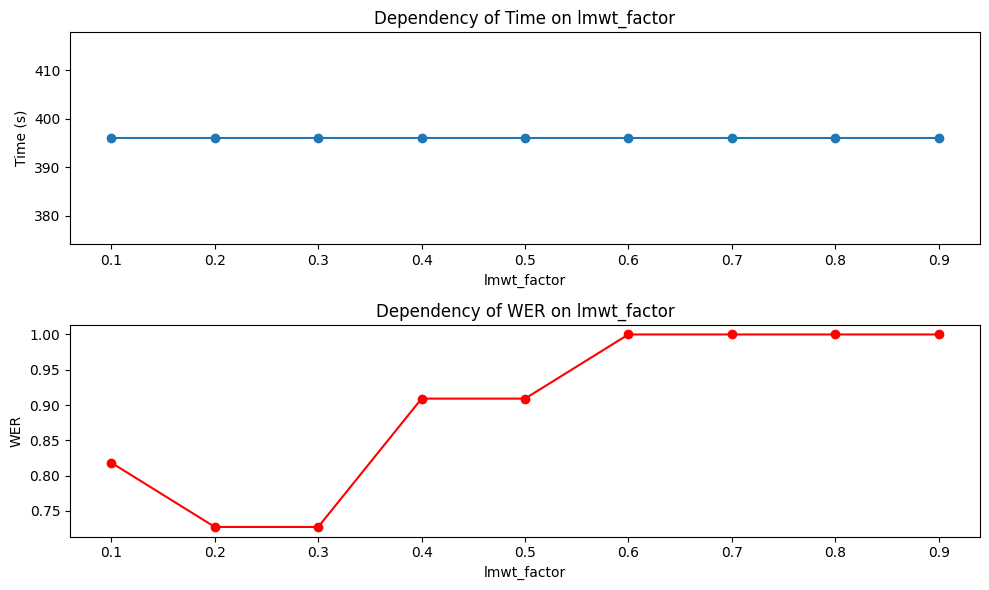

In [33]:
def test_lmwt_factor(example = example, example_ref=example_ref, lmwt_factor=0.1,stay_in_silence_penalty=0.0, word_insertion_penalty=1.0, beam=3):
    h_fst = create_h_wfst()
    l_fst = create_Lwfst_from_file(stay_in_silence_penalty=stay_in_silence_penalty, word_insertion_penalty=word_insertion_penalty)
    lm = kenlmLikeWFST(kenlm.LanguageModel('resources/lab4/3gram.arpa'), lmwt_factor=lmwt_factor)
    ASR = BeamSearcher(am2phone_mapping=AM_PHONES,
                   graph=OnTheFlyCompose([h_fst, l_fst, lm]),
                   beam_size=beam)
    hyp = ASR.decode(example)
    return hyp.time, jiwer.wer(example_ref, ' '.join(hyp.words))

experiment(lmwt_factors, test_lmwt_factor, "lmwt_factor")

  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses
best stay_in_silence_penalty: 0.0


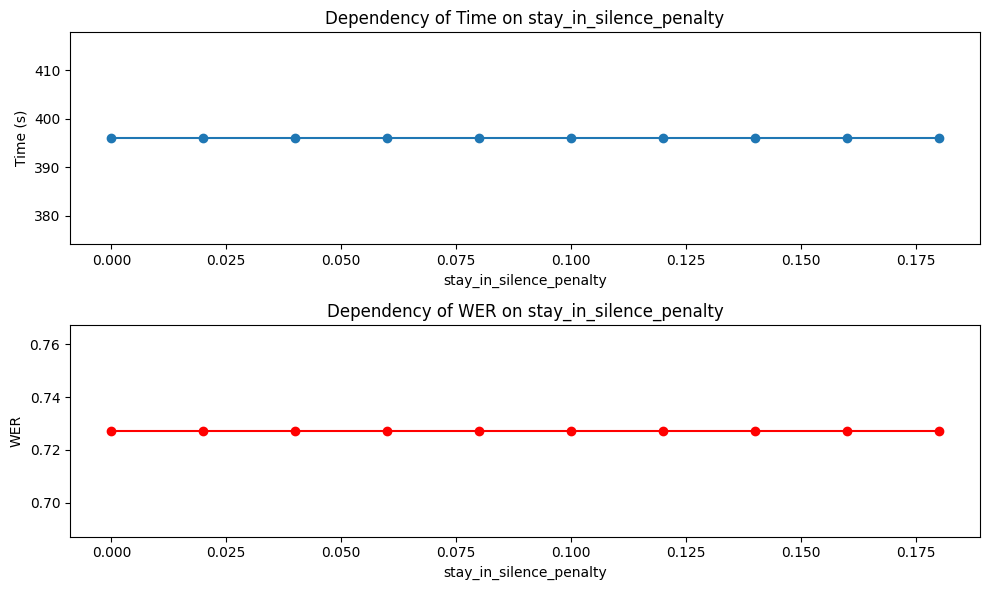

  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses
best word_insertion_penalty: 0.4


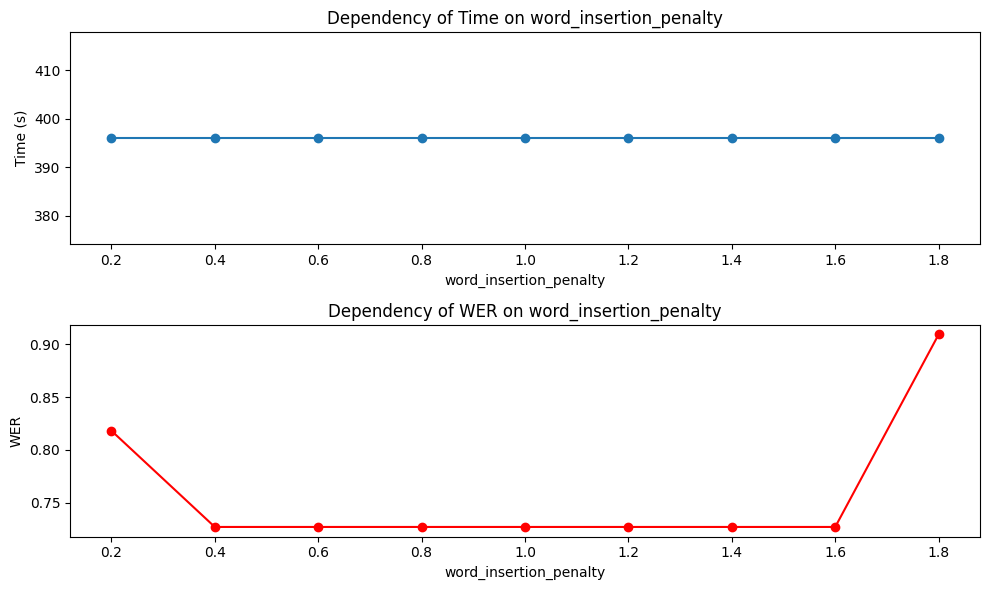

  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 2 hypotheses


  0%|          | 0/397 [00:00<?, ?it/s]

Found 1 hypotheses
best beam: 6


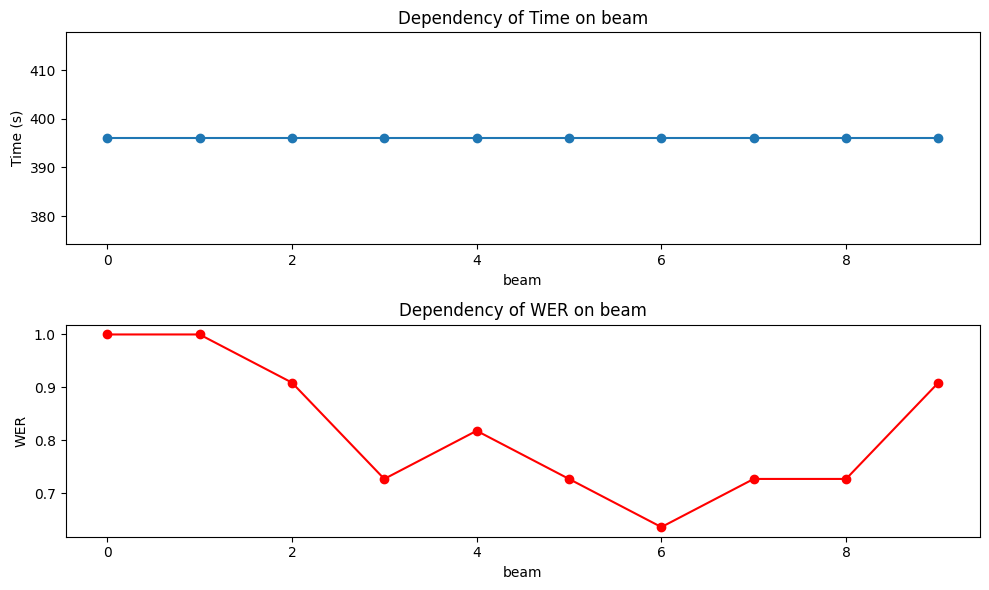

In [34]:
experiment(stay_in_silence_penalties, test, "stay_in_silence_penalty")
experiment(word_insertion_penalties, test, "word_insertion_penalty")
experiment(beams, test, "beam")

# Дополнительное задание (2 балла)
Декодируйте всю коллекцию am_nlogprobs с подобраными ранее параметрами и посчитайте WER на этой выборке

In [36]:
files = []
for d, _, fs in os.walk("timit/data/TEST/"):
    for f in fs:
        full_path = f'{d}/{f}'
        if f.endswith('.WRD'):
            files.append(full_path.split(".")[0])

examples = []
example_refs = []
for file in files:
    try:
        examples.append(am_nlogprobs[file])
        with open(f'{file}.TXT') as f:
            example_ref = ' '.join(f.read().replace('.', ' ').split()[2:])
            example_refs.append(example_ref)
    except Exception as e:
        continue

In [40]:
%%capture

wers = [test(example, example_ref, 0.2, 0.0, 0.4, 6)[1] for example, example_ref in zip(examples, example_refs)]

In [41]:
print("Average WER:", sum(wers)/len(wers))

Average WER: 1.1327272727272728
